In [1]:
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F
# torch.cuda.set_device(1)
import models, train, utils
from importlib import reload
reload(models)
reload(train)
reload(utils)

<module 'utils' from '/home/cse/btech/cs1180416/col870-deep-learning/A2/utils.py'>

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
query_X = torch.load('data/pt-cache/query_X.pt', map_location='cpu')
target_X = torch.load('data/pt-cache/target_X.pt', map_location='cpu')
query_y = torch.load('data/pt-cache/query_y.pt', map_location='cpu')
target_y = torch.load('data/pt-cache/target_y.pt', map_location='cpu')

In [4]:
train_query_X, val_query_X, test_query_X = torch.split(query_X, [8000,1000,1000], dim=0)
train_target_X, val_target_X, test_target_X = torch.split(target_X, [8000,1000,1000], dim=0)

In [ ]:
dnet_val

In [4]:
test_X = query_X[:100].to(device)
test_q = query_y[:6400]
test_t = target_y[:6400]

In [11]:
from IPython import display
from ipywidgets import Output
import matplotlib.pyplot as plt
import torch
torch.backends.cudnn.benchmark = True
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

def train_net(net, X, Y, lr, batch_size, n_epochs, device, show_step=None):
    plt_out = Output()
    display.display(plt_out)
    net.train()
    net = net.to(device)
    loader = DataLoader(TensorDataset(X, Y), batch_size=batch_size, shuffle=True)
    opt = optim.Adam(net.parameters(), lr=lr)
    pos_losses = []
    neg_losses = []
    rrn_accs = []
    dnet_accs = []
    ctr = 0
    for epoch in tqdm(range(n_epochs), 'epochs'):
        for X, Y in tqdm(loader, 'batches', leave=False):
            ctr += 1
            X = X.to(device)
            Y = Y.to(device)
            pos_loss, neg_loss = net.criterion(net(X), Y)
            pos_losses.append(pos_loss.item())
            neg_losses.append(neg_loss.item())
            opt.zero_grad()
            (pos_loss+7*neg_loss).backward()
            nn.utils.clip_grad_norm_(net.parameters(), 1)
            opt.step()
            
            with torch.no_grad():
                rrn_pred = net.predict(test_X)
                rrn_acc = accuracy_score(test_t, rrn_pred.view(-1).cpu())
                rrn_accs.append(rrn_acc)
                dnet_pred = net.dnet.predict(utils.split_sudoku_img(test_X))
                dnet_acc = accuracy_score(test_q, dnet_pred.view(-1).cpu())
                dnet_accs.append(dnet_acc)
                
            if show_step is not None and ctr % show_step == 0:
                with plt_out:
                    plt.figure()
                    plt.plot(pos_losses, label='pos')
                    plt.plot(neg_losses, label='neg')
                    plt.plot(rrn_accs, label='rrn acc')
                    plt.plot(dnet_accs, label='dnet acc')
                    plt.legend()
                    plt.xlabel('batches')
                    plt.ylabel('loss')
                    plt.tick_params(labelright=True, right=True)
                    plt.grid(axis='y')
                    plt.yticks(torch.arange(0,1.1,0.1))
                    plt.title(f'epoch={epoch} ctr={ctr} lr={lr} batch_size={batch_size}')
                    plt.show()
                    plt.close()
#                     plt_out.clear_output(wait=True)
    return losses

In [12]:
rrn = models.DigitRRN(16).to(device)

In [13]:
rrn.dnet.load_state_dict(torch.load('data/pt-cache/dnet.pt', map_location='cpu'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [14]:
rrn.rrn.load_state_dict(torch.load('data/pt-cache/rrn_16.pt', map_location='cpu'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [15]:
def freeze(net):
    for p in net.parameters():
        p.requires_grad = False

In [ ]:
train_net(rrn, query_X, target_X,
          lr=1e-3, batch_size=32, n_epochs=1000, device=device, show_step=100)

Output()

In [20]:
torch.save(rrn.state_dict(), 'data/pt-cache/digit_rrn.pt')

In [16]:
q = query_X[1].to(device)[None,...]

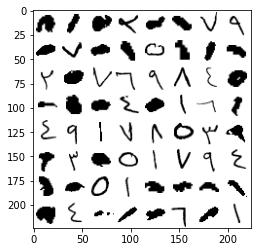

In [17]:
utils.viz_images(q, nrow=1)

In [18]:
torch.argmax(rrn.dnet(utils.split_sudoku_img(q)), dim=-1).view(8,8)

tensor([[0, 0, 0, 1, 0, 0, 1, 7],
        [0, 1, 0, 0, 3, 0, 0, 0],
        [1, 0, 1, 7, 7, 6, 2, 0],
        [0, 0, 0, 2, 0, 8, 7, 3],
        [2, 7, 8, 1, 6, 3, 1, 0],
        [0, 1, 0, 3, 8, 1, 7, 2],
        [0, 0, 3, 8, 0, 0, 0, 0],
        [0, 2, 1, 1, 0, 7, 0, 8]], device='cuda:1')

In [19]:
torch.argmax(F.softmax(rrn(q), dim=-1), dim=-1).view(8,8)+1

tensor([[8, 3, 6, 1, 2, 7, 1, 7],
        [7, 1, 2, 7, 3, 1, 8, 6],
        [1, 8, 1, 7, 7, 6, 2, 3],
        [3, 6, 7, 2, 7, 8, 7, 1],
        [2, 7, 8, 1, 6, 3, 1, 7],
        [6, 1, 7, 3, 8, 1, 7, 2],
        [1, 7, 3, 8, 1, 2, 6, 1],
        [7, 2, 1, 6, 1, 7, 3, 8]], device='cuda:1')